In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
# Install if necessary (should already exist on Kaggle)
# !pip install transformers datasets

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm


Load Teacher and Student Models	

In [24]:
# Load Student (small) model: distilbert-base-uncased
student_model_name = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)
student_config = AutoConfig.from_pretrained(student_model_name)
student_config.output_hidden_states = True
student_config.num_labels = 2
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_model_name,
    config=student_config
)

# Load Teacher (large) model: bert-base fine-tuned on MRPC
teacher_model_name = "textattack/bert-base-uncased-MRPC"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_config = AutoConfig.from_pretrained(teacher_model_name)
teacher_config.output_hidden_states = True
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_model_name,
    config=teacher_config
)

print("Loaded student and teacher models.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded student and teacher models.


Load and Tokenize MRPC Dataset (Student Tokenizer)

In [25]:
# Load MRPC dataset
dataset = load_dataset("glue", "mrpc")
train_dataset = dataset["train"]
valid_dataset = dataset["validation"]

# Tokenization function using student tokenizer
def tokenize_function(example):
    return student_tokenizer(
        example['sentence1'], example['sentence2'],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

# Set format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Loaded and tokenized MRPC dataset.")


Loaded and tokenized MRPC dataset.


Prepare Training Setup

In [26]:
# Loss function for distillation
T  = 2.0        # temperature
alpha = 0.5     # supervised CE weight
beta  = 0.5     # distillation KL weight
gamma = 1.0     # cosine hidden-state weight

ce_loss_fn = nn.CrossEntropyLoss()
kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
cosine_loss_fn = nn.CosineEmbeddingLoss()
# Optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=2e-5)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=64)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

# Teacher fixed
teacher_model.eval()

# Tracking lists
train_losses = []
val_accuracies = []

print("Training setup complete.")


Training setup complete.


In [27]:
epochs = 10
for epoch in range(epochs):
    student_model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        # ----- forward -----
        with torch.no_grad():
            teacher_out = teacher_model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                output_hidden_states=True,
            )
            teacher_logits   = teacher_out.logits / T          # soften
            teacher_probs    = nn.functional.softmax(teacher_logits, dim=-1)
            teacher_hiddens  = teacher_out.hidden_states       # tuple length 13 (emb + 12 layers)

        student_out = student_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            output_hidden_states=True,
        )
        student_logits  = student_out.logits / T
        student_logprob = nn.functional.log_softmax(student_logits, dim=-1)
        student_hiddens = student_out.hidden_states            # tuple length 7 (emb + 6 layers)

        # ----- 1) supervised CE on gold labels -----
        ce_loss = ce_loss_fn(student_out.logits, batch["label"])

        # ----- 2) distillation KL on softened logits -----
        kl_loss = kl_loss_fn(student_logprob, teacher_probs) * (T * T)

        # ----- 3) cosine difference on hidden states -----
        # align each student layer with every other teacher layer (as in paper)
        cos_losses = []
        for i in range(1, len(student_hiddens)):        # skip embeddings
            s = student_hiddens[i]
            t = teacher_hiddens[i*2]                    # teacher layers 2,4,6,8,10,12
            cos_losses.append(
                cosine_loss_fn(
                    s.view(-1, s.size(-1)),             # flatten batch*seq, hidden
                    t.view(-1, t.size(-1)),
                    torch.ones(s.size(0)*s.size(1), device=device)  # target +1
                )
            )
        cos_loss = torch.stack(cos_losses).mean()

        # ----- total loss -----
        loss = alpha * ce_loss + beta * kl_loss + gamma * cos_loss

        # ----- back-prop -----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Triple-Loss: {avg_loss:.4f}")

    # ---------- validation ----------
    student_model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = student_model(input_ids=batch["input_ids"],
                                   attention_mask=batch["attention_mask"]).logits
            preds = logits.argmax(dim=-1)
            correct += (preds == batch["label"]).sum().item()
            total   += batch["label"].size(0)
    acc = correct / total
    val_accuracies.append(acc)
    print(f" Validation Accuracy: {acc:.4f}")


Epoch 1 Training: 100%|██████████| 115/115 [01:04<00:00,  1.79it/s]


Epoch 1 — Triple-Loss: 0.6313
 Validation Accuracy: 0.7672


Epoch 2 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 2 — Triple-Loss: 0.5146
 Validation Accuracy: 0.8358


Epoch 3 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 3 — Triple-Loss: 0.4675
 Validation Accuracy: 0.7917


Epoch 4 Training: 100%|██████████| 115/115 [01:02<00:00,  1.85it/s]


Epoch 4 — Triple-Loss: 0.4382
 Validation Accuracy: 0.8235


Epoch 5 Training: 100%|██████████| 115/115 [01:02<00:00,  1.85it/s]


Epoch 5 — Triple-Loss: 0.4193
 Validation Accuracy: 0.8211


Epoch 6 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 6 — Triple-Loss: 0.4081
 Validation Accuracy: 0.8554


Epoch 7 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 7 — Triple-Loss: 0.4020
 Validation Accuracy: 0.8407


Epoch 8 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 8 — Triple-Loss: 0.3981
 Validation Accuracy: 0.8407


Epoch 9 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 9 — Triple-Loss: 0.3939
 Validation Accuracy: 0.8456


Epoch 10 Training: 100%|██████████| 115/115 [01:01<00:00,  1.86it/s]


Epoch 10 — Triple-Loss: 0.3906
 Validation Accuracy: 0.8186


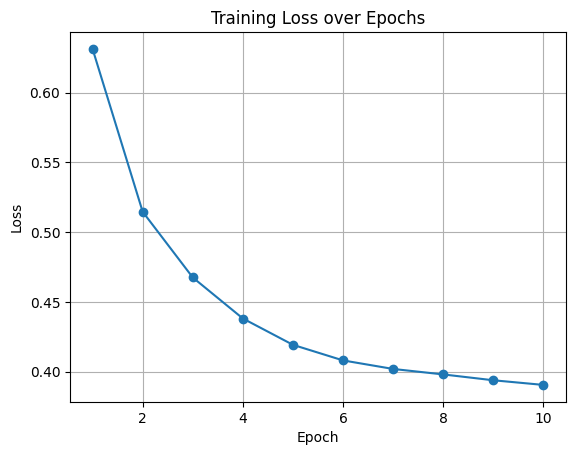

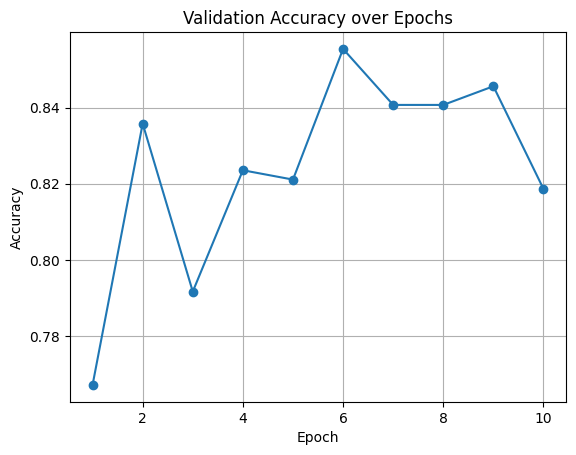

In [28]:
# Plot training loss
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(range(1, epochs+1), val_accuracies, marker='o')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [29]:
# Dummy batch
dummy_batch = next(iter(val_loader))
dummy_batch = {k: v.to(device) for k, v in dummy_batch.items()}

student_model.eval()

# Inference timing
start = time.time()
with torch.no_grad():
    _ = student_model(
        input_ids=dummy_batch["input_ids"],
        attention_mask=dummy_batch["attention_mask"],
    )
end = time.time()

inference_time_per_batch = end - start
inference_time_per_sample = inference_time_per_batch / dummy_batch["input_ids"].size(0)

print(f"Inference time per batch: {inference_time_per_batch:.4f} seconds")
print(f"Inference time per sample: {inference_time_per_sample*1000:.2f} ms")


Inference time per batch: 0.0059 seconds
Inference time per sample: 0.09 ms


In [30]:
def teacher_tokenize_function(example):
    return teacher_tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_token_type_ids=True,
    )

teacher_valid_dataset = dataset["validation"].map(teacher_tokenize_function,
                                                  batched=True)

# KEEP token_type_ids in the PyTorch columns
teacher_valid_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "token_type_ids", "label"],
)
teacher_val_loader = DataLoader(teacher_valid_dataset, batch_size=64)


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

In [31]:
teacher_model.eval()
correct = total = 0
with torch.no_grad():
    for batch in teacher_val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        preds = teacher_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],   # <- add this
        ).logits.argmax(dim=-1)
        correct += (preds == batch["label"]).sum().item()
        total   += batch["label"].size(0)
teacher_acc = correct / total
print(f"Teacher Validation Accuracy: {teacher_acc:.4f}")
print(f"Student Validation Accuracy: {val_accuracies[-1]:.4f}")


Teacher Validation Accuracy: 0.8775
Student Validation Accuracy: 0.8186


In [32]:
# Save models temporarily
torch.save(teacher_model.state_dict(), "teacher_model.pt")
torch.save(student_model.state_dict(), "student_model.pt")

# Model size (MB)
teacher_size_mb = os.path.getsize("teacher_model.pt") / (1024 * 1024)
student_size_mb = os.path.getsize("student_model.pt") / (1024 * 1024)

In [33]:
# Inference speed test (CPU for fairness)
def measure_inference_time(model, tokenizer):
    model_cpu = model.to("cpu")
    inputs = tokenizer(
        "The quick brown fox jumps over the lazy dog.",
        "This is a second sentence.",
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    )

    with torch.no_grad():
        _ = model_cpu(**inputs)

    # Time measurement
    start = time.time()
    with torch.no_grad():
        _ = model_cpu(**inputs)
    end = time.time()

    return (end - start) * 1000  # milliseconds

teacher_latency_ms = measure_inference_time(teacher_model, teacher_tokenizer)
student_latency_ms = measure_inference_time(student_model, student_tokenizer)

In [34]:
print("------ MODEL COMPARISON ------")
print(f"Teacher Accuracy     : {teacher_acc:.4f}")
print(f"Student Accuracy     : {val_accuracies[-1]:.4f}")
print()
print(f"Teacher Model Size   : {teacher_size_mb:.2f} MB")
print(f"Student Model Size   : {student_size_mb:.2f} MB")
print(f"Size Reduction       : {(1 - student_size_mb/teacher_size_mb)*100:.1f}% smaller")
print()
print(f"Teacher Latency      : {teacher_latency_ms:.2f} ms")
print(f"Student Latency      : {student_latency_ms:.2f} ms")
print(f"Latency Speedup      : {(teacher_latency_ms/student_latency_ms - 1)*100:.1f}% faster")
print()
print(f"Performance Retention: {(val_accuracies[-1]/teacher_acc)*100:.1f}% of teacher")
print("--------------------------------")


------ MODEL COMPARISON ------
Teacher Accuracy     : 0.8775
Student Accuracy     : 0.8186

Teacher Model Size   : 417.73 MB
Student Model Size   : 255.45 MB
Size Reduction       : 38.8% smaller

Teacher Latency      : 57.98 ms
Student Latency      : 29.17 ms
Latency Speedup      : 98.7% faster

Performance Retention: 93.3% of teacher
--------------------------------
